In [2]:
import numpy as np
import datetime as dt
from time import mktime
import os


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
def format_crashes():
    """Format all crash data for analysis.""" 
    Travisdf = pd.read_csv(r"C:\Users\140318\Desktop\Python\Python3x\Austin-Crash-Analytics\Spatial\csv\TravisMaster.csv")
    Travisdf['Crash_Date'] = pd.to_datetime(Travisdf['Crash_Date'], format='%Y-%m-%d %X')
    Travisdf['Crash_Time'] = pd.to_datetime(Travisdf['Crash_Time']).dt.hour
    Travisdf=Travisdf.set_index('Crash_ID')
    sev_codes = ['UNKNOWN',
                'INCAPACITATING INJURY',
                'NON-INCAPACITATING INJURY',
                'POSSIBLE INJURY',
                'KILLED',
                'NOT INJURED']
    Travisdf['Crash_Severity_Code'] = Travisdf['Crash_Sev_ID'] 
    Travisdf['Crash_Severity_Code'].replace({0:0, 1:4, 2:3, 3:2, 4:5, 5:1}, inplace=True)
    Travisdf['Death_Cnt'].replace(0, np.NaN, inplace=True)
    i = 0
    for code in sev_codes:
        Travisdf['Crash_Sev_ID'].replace(i, code, inplace=True)
        i += 1
    return Travisdf

In [4]:
def format_contributing_factors():
    """Format contributing factor data"""
    csvdir = r"C:\Users\140318\Desktop\Python\Python3x\Austin-Crash-Analytics\Spatial\csv"
    concat_list = []
    for root, dirs, files in os.walk(csvdir, topdown=False):
        for name in files:
            if name.split('\\')[-1].split('.')[0].endswith('Units'):
                df = pd.read_csv('{0}\\{1}'.format(root, name), index_col=None,low_memory=False)
                concat_list.append(df)
    df = pd.concat(concat_list)
    TravisUnitsdf = pd.concat([df['Crash_ID'],
                               df['Contrib_Factr_1_ID'],
                               df['Contrib_Factr_2_ID'],
                               df['Contrib_Factr_3_ID']], axis=1)
    # Convert codes
    for i in range(1,4):
        TravisUnitsdf['Contrib_Factr_{0}_ID'.format(i)].replace(67, 'UNDER INFLUENCE - ALCOHOL', inplace=True)
        TravisUnitsdf['Contrib_Factr_{0}_ID'.format(i)].replace(68, 'UNDER INFLUENCE - DRUG', inplace=True)
        TravisUnitsdf['Contrib_Factr_{0}_ID'.format(i)].replace(45, 'HAD BEEN DRINKING', inplace=True)

    # Export to csv for spatial analysis
    TravisUnitsdf.to_csv('{0}\\ContributingFactors.csv'.format(csvdir))
    return TravisUnitsdf

In [5]:
def plot_all():
    Travisdf.groupby(['Crash_Date'])[['Tot_Injry_Cnt', 'Death_Cnt']].sum().plot(figsize=(40,15),
                                                                                linestyle='',
                                                                                marker='o', grid=1)
    plt.style.use('seaborn-bright') 
    plt.xlabel('')
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=30)
    plt.ylabel('Crash Injuries & Deaths', fontsize=45)
    plt.legend(['Injuries', 'Deaths'], markerscale = 2, fontsize=30)
    plt.show()

In [6]:
def plot_hourly():
    """Plots figures for 24 hour trends in county crash injuries and deaths."""
    hourly = Travisdf.groupby(['Crash_Time'])[['Tot_Injry_Cnt', 'Death_Cnt']].sum().reset_index()
    plt.style.use('fivethirtyeight') 
    f, axes = plt.subplots(2, 1, figsize=(10, 5))
    plt.suptitle('Crash Death and Injury Times in Travis County', size=20)


    # Hourly injury plot
    Y = np.array(list(hourly['Crash_Time']))
    P = np.array(list(hourly['Tot_Injry_Cnt']))
    f2 = interp1d(Y, P, kind='cubic')
    xnew = np.linspace(min(Y), max(Y), 100)
    axes[0].plot(Y, P, 'H', xnew, f2(xnew), '--', linewidth=4.5, markersize=13)
    axes[0].set_ylabel('Injuries', size=20)
    axes[0].axvline(x=17, linestyle='--', linewidth=2.5)
    axes[0].text(18, 7450, '5:00 PM', size=15)
    axes[0].grid(linewidth=.5)
    axes[0].set_yticks([0])

    # Hourly death plot
    Y = np.array(list(hourly['Crash_Time']))
    P = np.array(list(hourly['Death_Cnt']))
    f2 = interp1d(Y, P, kind='cubic')
    xnew = np.linspace(min(Y), max(Y), 100)
    axes[1].plot(Y, P, 'H', xnew, f2(xnew), '--', linewidth=4.5, markersize=13)
    axes[1].set_ylabel('Deaths', size=20)
    axes[1].set_xlabel('Crash Time of Day', size=20)
    axes[1].axvline(x=2, linestyle='--', linewidth=2.5)
    axes[1].text(2.8, 60, '2:00 AM', size=15)
    axes[1].axvline(x=21, linestyle='--', linewidth=2.5)
    axes[1].text(21.9, 60, '9:00 PM', size=15)
    axes[1].set_yticks([0])
    axes[1].grid(linewidth=.5)
    plt.show()
    
    # DWI Hourly histogram
    DWIdf = pd.read_csv(r"C:\Users\140318\Desktop\Python\Python3x\Austin-Crash-Analytics\Spatial\csv\Alc&Drug\TravisMasterAlc.csv")
    DWIdf = DWIdf.set_index('Crash_ID')
    ax = sns.distplot(np.array(DWIdf['Crash_Time']))
    plt.title('Distribution of Alcohol Related Crash Times - Travis County', size=18)
    plt.axvline(x=200, linestyle='--', linewidth=2.5)    
    plt.text(290, .00105, '2:00 AM', size=15)
    plt.axvline(x=2130, linestyle='--', linewidth=2.5)
    plt.text(2150, .00105, '9:30 PM', size=15)
    plt.yticks([0])
    plt.show()

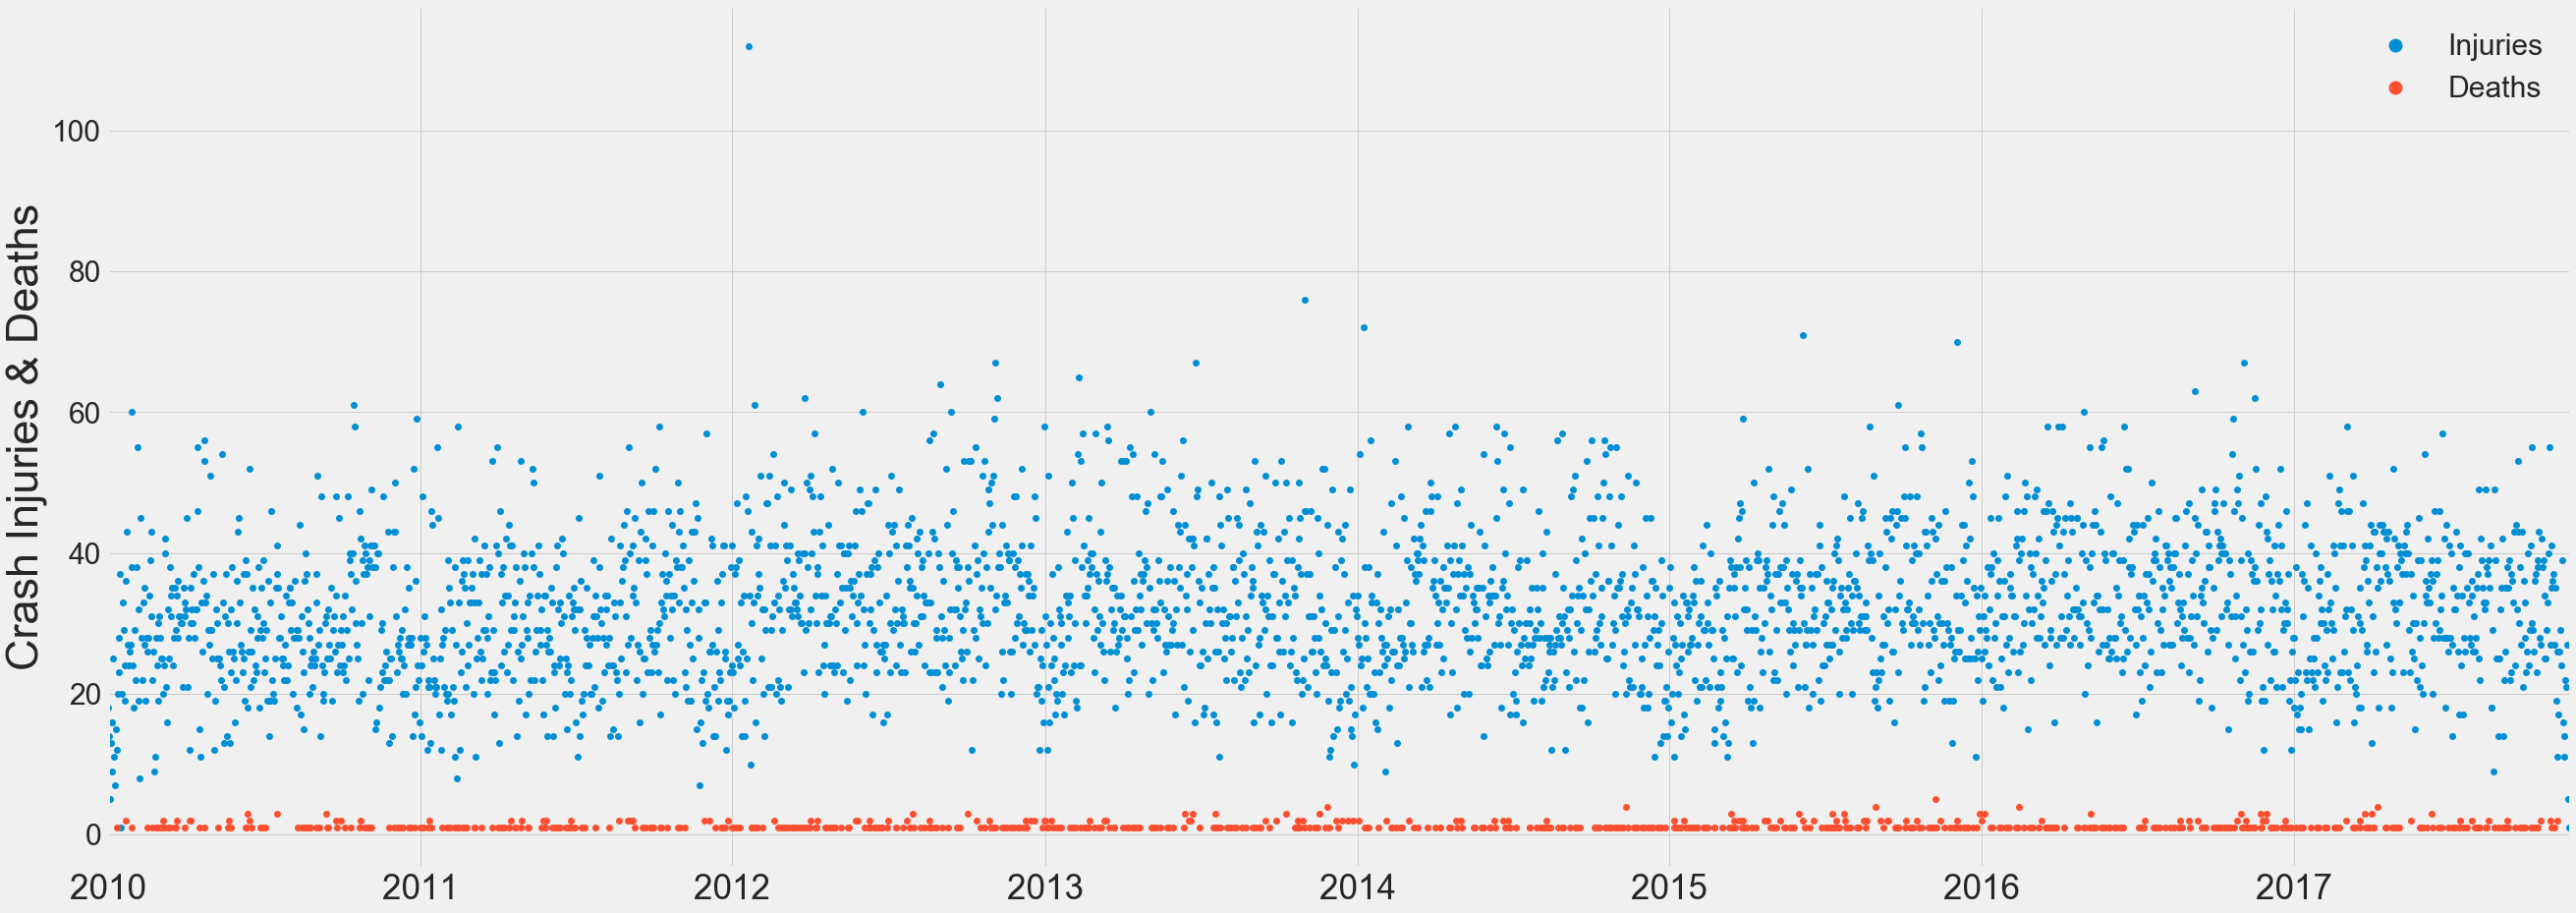

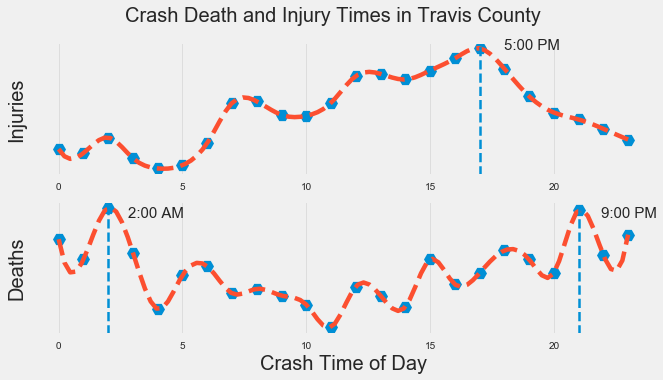

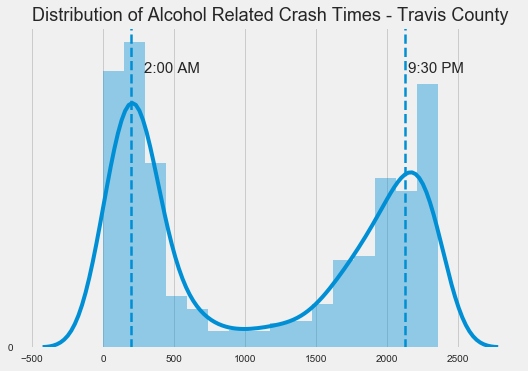

In [9]:
Travisdf = format_crashes()
plot_all()
plot_hourly()